# TD 4 - 30th of Jan. 2024

Faisal Jayousi: jayousi@unice.fr

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

## Forward model

In SMLM type data, the acquisition consist of a blurred and noisy image of a molecule sample (the ground truth image). 
Let $x\in\mathbb R^n$ be the ground truth image. 
The microscope only allows us to have access to an undersampled, blurred and noisy version $$y=Ax+\eta,$$
where $A:\mathbb R^n \longrightarrow \mathbb R^m$, $n=Lm$ is the forward operator (blurring and undersampling) and $\eta\in\mathbb R^m$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$. $L>0$ is called the super-resolution factor. 

The forward operator can be modeled as $A=\tilde{M_L}H$ where 

1) $H:\mathbb R^n \longrightarrow \mathbb R^n$ is the blurring operator 
2) $\tilde{M_L}:\mathbb R^n \longrightarrow \mathbb R^m$ is the undersampling operator which averages the values on $L\times L$ patches of pixels.


* Load the ground truth image, and blur it using a Gaussian kernel $\sigma_h=20$.

In [3]:
def scale(img):
    return ((img - img.min())/(img.max() - img.min()) * 255)

def snr(xref, x):
    return 20 * np.log10(np.linalg.norm(xref) / np.linalg.norm(xref-x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


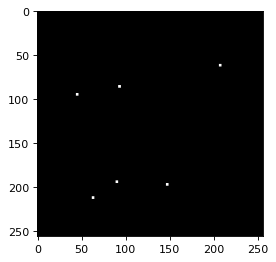

In [4]:
# load the images
x = np.float64(plt.imread('gt.png'))
# rescale the images in the range 0-255
x = scale(x)
# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(121)
plt.imshow(x, cmap='gray')


In [5]:
x.shape

(256, 256, 3)

In [6]:
# it has 3 channels so we will use the 

In [7]:
x = x[:,:,0]
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

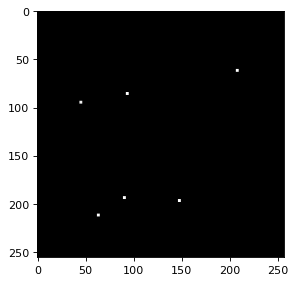

In [8]:
plt.figure(figsize=(8, 4), dpi=80)
plt.imshow(x, cmap='gray')

In [9]:
# gaussian_kernal
sigma = 20
n = x.shape[0]
t = np.concatenate( (np.arange(0, n/2+1), np.arange(-n/2, -1)) )

Y, X = np.meshgrid(t, t)
h = np.exp( -(X**2+Y**2)/(2.0*float(sigma)**2) )
h = h / np.sum(h)
hf = np.real(np.fft.fft2(h))

In [10]:
def blur_operator(x, h):
    return np.real(np.fft.ifft2(h * np.fft.fft2(x)))

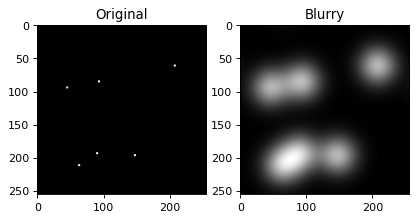

In [27]:
blurred_image =blur_operator(x, hf)

plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(121)
plt.imshow(x, cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(y1_bl, cmap='gray')
plt.title('Blurry')
plt.show()

In [28]:
def downsampling_matrix(n: int, L: int):
    """ returns $M_L$
    """
    m = int(n/L)
    M = np.zeros([m, n])
    for i in np.arange(m):
        M[i, L*i:L*i+L] = 1
    return M

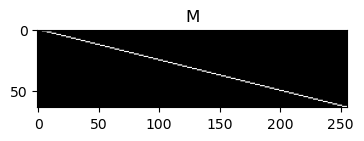

In [29]:
L = 4
# M = downsampling_matrix(np.shape(gt)[0], L)
M = downsampling_matrix(np.shape(x)[0], L)


plt.figure(figsize=(4,4))
plt.imshow(M, cmap='gray')
plt.title('M')
plt.show()

* Give the mathematical expression of the downsampled image. Apply it to the blurred image.

In [30]:
def downsample(x, M):
    """ returns downsampled version of x using M
    """
    return  M @ x @ M.T  # for 2D downsampling

def blur(x, h):
    """ returns blurred image
    """
    return np.real(np.fft.ifft2(h * np.fft.fft2(x)))



def forward(x, h, M):
    """ applies forward operator on x (blur + downsampling)
    """
    x_blurred = blur(x, h)
    x_downsampled = downsample(x_blurred, M)
    return x_downsampled

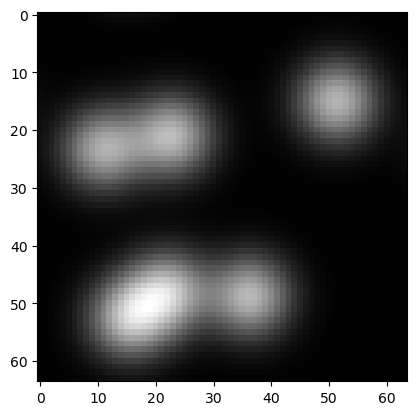

In [31]:
# y = forward(gt, h, M)
y = forward(x, hf, M)

plt.imshow(y, cmap='gray')
plt.show()

Now we need to generate a noisy realisation of the downsampled image in order to obtain a realistic acquisition. Add some Gaussian noise with $\sigma=0.3$.

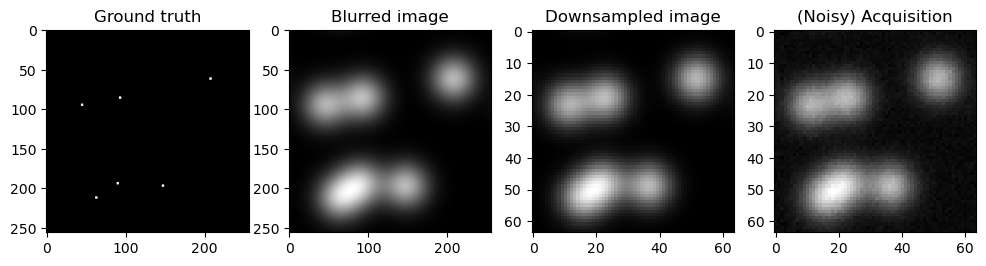

In [32]:
# in this way you will have a deterministic result
np.random.seed(24)

sigma_noise = 0.3
noise = sigma_noise * np.random.randn(*y.shape)   #  Gaussian noise

acq = y + noise

# plots
plt.figure(figsize=(12, 4))
plt.subplot(141)
# plt.imshow(gt, cmap='gray')
plt.imshow(x, cmap='gray')

plt.title('Ground truth')
plt.subplot(142)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.subplot(143)
plt.imshow(y, cmap='gray')
plt.title('Downsampled image')
plt.subplot(144)
plt.imshow(acq, cmap='gray')
plt.title('(Noisy) Acquisition')
plt.show()

## Variational problem
We will use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\lambda \mathcal{R}(x) +\texttt{i}_{\ge 0}(x) $$
where $\mathcal{R}(x)$ is the regulariser or penalty term. Given the nature of the data, what would you choose?

* Write your answer here.

In [ ]:
# fidelity
def fidelity(x, h, M, y):
    Ax = M @ np.real(np.fft.ifft2(h * np.fft.fft2(x))) @ M.T  
    return 0.5 * np.linalg.norm(Ax - y) ** 2

# gradient of the fidelity term
def gradient(x, h, M, y):
    return ...

# cost function
def cost_function(x, h, M, y, lmbda):
    return ...


# compute the Lipschitz constant Lips
Lips = ...

Define the soft thresholding function below. This function is needed during the backward step.

In [ ]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
    return ...

You have now the elements to define the function for the FB algorithm.

In [ ]:
# input parameters
# x0 is the initialisation
# tau is the stepsize
# lambda is the regularisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def FB(x0, tau, lmbda, y, h, M_L, epsilon, maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)

    for k in np.arange(maxiter):
        if (k + 1) % 100 == 0:
            print(f'Iter {k+1}/{maxiter}')

        # forward step: gradient descent of f
        xkk = ...

        # backward step
        xkk = ...

        # positivity constraints
        xkk = ...

        # compute the cost function
        cost[k] = cost_function(xkk, h, M_L, y, lmbda)
        norms[k] = np.linalg.norm(xkk-xk, 'fro')

        # update the iteration
        xk = xkk

        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

Useful: define a function to plot reconstruction, cost function and relative changes of the iterates.

In [ ]:
def plot_results(rec, cost, norms):
    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(1, 3, 2)
    plt.imshow(acq, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(1, 3, 3)
    plt.imshow(rec, cmap='gray')
    plt.title('Reconstruction')
    plt.show()

    # plot how the cost function decreases and how the iterates converge
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(1, 2, 2)
    plt.plot(norms)
    plt.xlabel('$k$')
    plt.ylabel("$||x^{(k+1)}-x_{k}||$")
    plt.title('Relative difference in the reconstructions')
    plt.show()

Try the algorithm.

In [ ]:
dim = (n, n)
x0 = np.zeros(dim)
tau = ...
lmbda = 5
maxiter = 1000
epsilon = 0.


# compute the reconstruction
rec, cost, norms = FB(x0, tau, lmbda, acq, h, M, epsilon, maxiter)
plot_results(rec, cost, norms)

## FISTA

Typically, FISTA converges faster than ISTA. FISTA is known to have a convergence rate of $\mathcal{O}(1/k^2)$, whereas ISTA has a convergence rate of $\mathcal{O}(1/k)$. This means that FISTA can achieve a solution with a certain accuracy in fewer iterations compared to ISTA.

In [ ]:
# input parameters
# x0 is the initialisation
# tau is the stepsize
# lambda is the regularisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# M_L is the downsampling operator
# maxiter is the maximum number of iterations

def FISTA(x0, tau, lmbda, y, h, M_L, maxiter):
    return ...

In [ ]:
dim = (n, n)
x0 = np.zeros(dim)
tau = ...
lmbda = 5
maxiter = 100

rec, cost, norms = FISTA(x0, tau, lmbda, acq, h, M, maxiter)
plot_results(rec, cost, norms)